# Heart Disease Prediction

*The purpose of this project is to predict whether or not a patient has heart disease based on a some medical metrics and factors. This may be useful to detect presence of heart disease early or at least contribute to that goal.*

## Data Exploration

We begin by importing the main Python packages intended for data exploration and visualization, as well as reading in the data as a Pandas dataframe.

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

heart = pd.read_csv('heart.csv')

Now, we are collecting the specifications of the data. We see that there are 11 columns and 918 rows. The column values have various types, some are numerical(integers and floats) and some are objects. 

For additional context, let's look at what the attributes represent.
+ Age - years old
+ Sex
  + 'M'
  + 'F'
+ ChestPainType
  + 'TA'- typical angina
  + 'ATA' - atypical angina
  + 'NAP' - non-anginal pain
  + 'ASY' - asymptomatic
+ RestingBP - resting blood pressure in mmHg
+ Cholesterol - serum cheolsterol in mm/dl
+ FastingBS - fasting blood sugar
  + 1 - if FastingBS > 120 mg/dl
  + 0 - if FastingBS <= 120 mg/dl
+ Resting ECG - resting electrocardiogram results
  + 'Normal' - normal
  + 'ST' - has ST-T wave abnormality
  + 'LVH' - showing some left ventricular hypertrophy (by Estes' criteria)
+ MaxHR - maximum heart rate achieved in bpm
+ Exercise Angina - exercise-induced angina
  + 'Y' - yes
  + 'N' - no
+ Oldpeak - oldpeak measured in depression
+ ST_Slope - slope of peak exercise ST segment
  + 'Up' - upsloping
  + 'Down' - downsloping
  + 'Flat'- flat
+ HeartDisease
  + 1 - heart disease
  + 0 - no heart disease

In [38]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


There are no null values.

In [39]:
heart.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

### *Numerical Data Exploration*

Using the dataframe's histogram method `hist`, we can develop a grid of distributions of the numerical values by column. The `FastingBS` and `HeartDisease` columns have binary values, either 0 or 1. It appears that most of the other distributions are bell-shaped. The `Fasting BS`, `Cholesterol`, and `Oldpeak` distributions seem to have right skews.

/var/folders/bd/r6v_8_t55cs5xwf17t68zlz80000gn/T/ipykernel_92477/4167307229.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  heart.hist(bins=50, ax=ax)


array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'RestingBP'}>,
        <AxesSubplot:title={'center':'Cholesterol'}>],
       [<AxesSubplot:title={'center':'FastingBS'}>,
        <AxesSubplot:title={'center':'MaxHR'}>,
        <AxesSubplot:title={'center':'Oldpeak'}>],
       [<AxesSubplot:title={'center':'HeartDisease'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

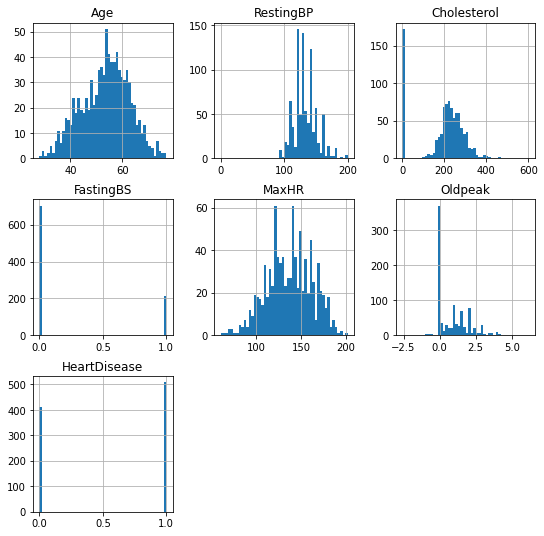

In [40]:
fig, ax = plt.subplots(figsize=(9, 9))
heart.hist(bins=50, ax=ax)

We can determine exactly how drastic the right skews are using the `skew` method of the dataframe. In the below table, we find that there is a significant right skew to those three distributions, which is a good indicator that we may need to implement some sort of standardization to those columns before fitting our model. 

In [41]:
skew = heart.skew()
pd.DataFrame(data=skew, columns=["Skew"])

# Standardize cholesterol
# Standardize old peak
# Split fasting BS when creating training set

/var/folders/bd/r6v_8_t55cs5xwf17t68zlz80000gn/T/ipykernel_92477/339807860.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  skew = heart.skew()


,Skew
Age,-0.195933
RestingBP,0.179839
Cholesterol,-0.610086
FastingBS,1.264484
MaxHR,-0.144359
Oldpeak,1.022872
HeartDisease,-0.215086


For additional numerical analysis, we can generate a correlation matrix and plot it on a heatmap. It appears that our target variable, `HeartDisease`, is correlated most with `MaxHR` and `Oldpeak`. This means that these variables should probably be included in our model. Furthermore, there appears to be a strong correlation between `Age` and `MaxHR`, as well as `Cholesterol` and `FastingBS`. These introduce some multicollinearity in our model, so it could cause increased variance and overfitting.

<AxesSubplot:>

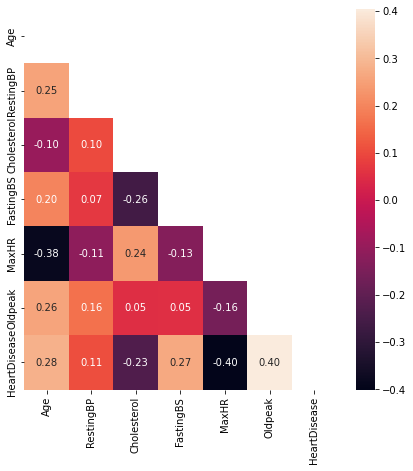

In [42]:
mask = np.triu(heart.corr())
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(data=heart.corr(), annot=True, fmt=".2f", ax=ax, mask=mask)

### *Categorical Data Exploration*

After numerical analysis, we can take a look at the composition our data. There are more slightly more people with heart disease in the dataset than those without. There is a significant difference in the number of males and females in the dataset. 

In [43]:
heart['HeartDisease'].value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

In [44]:
heart.groupby("Sex")["HeartDisease"].count()

Sex
F    193
M    725
Name: HeartDisease, dtype: int64

Comparing the average values in all numerical columns grouped by heart disease, we can see that subjects with heart disease have higher `RestingBP`, `FastingBS`, and `Oldpeak` values, and lower `Cholesterol`, and `MaxHR` values.

In [45]:
heart.groupby("HeartDisease")[["RestingBP", "Cholesterol", "FastingBS", "MaxHR", "Oldpeak"]].mean()

,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
HeartDisease,,,,,
0,130.180488,227.121951,0.107317,148.151220,0.408049
1,134.185039,175.940945,0.334646,127.655512,1.274213


Grouping the dataset by `HeartDisease` and `ChestPainType`, we find the distribution is different. `ChestPainType` is separated into  Creating a `countplot` of this data displays that those with heart disease have much more 'ASY' or asymptomatic chest pain than those without heart disease.  

In [46]:
heart.groupby(["HeartDisease", "ChestPainType"]).size()

HeartDisease  ChestPainType
0             ASY              104
              ATA              149
              NAP              131
              TA                26
1             ASY              392
              ATA               24
              NAP               72
              TA                20
dtype: int64

<AxesSubplot:xlabel='HeartDisease', ylabel='count'>

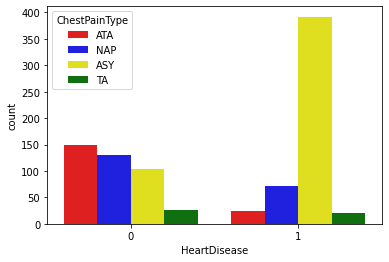

In [47]:
sns.countplot(x="HeartDisease", hue='ChestPainType', data=heart, palette=['red', 'blue','yellow','green'])

Grouping the data set by `HeartDisease` and `RestingECG` shows us that there are similar number of patients with normal `RestingECG` values in those with and without heart disease. There appear to be more heart disease patients with ST or LVH in their resting ECG's than patients without herat disease.

In [48]:
heart.groupby(["HeartDisease", "RestingECG"]).size()

HeartDisease  RestingECG
0             LVH            82
              Normal        267
              ST             61
1             LVH           106
              Normal        285
              ST            117
dtype: int64

<AxesSubplot:xlabel='HeartDisease', ylabel='count'>

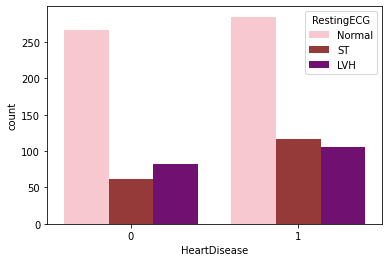

In [49]:
sns.countplot(x="HeartDisease", hue='RestingECG', data=heart, palette=['pink', 'brown', 'purple'])

Grouping by `HeartDisease` and `ST_Slope`, we can see that many more patients with heart disease have a flat ST slope and many more patients without heart disease have an upward facing ST slope than their respective counterparts. 

In [50]:
heart.groupby(["HeartDisease", "ST_Slope"])["HeartDisease"].count()

HeartDisease  ST_Slope
0             Down         14
              Flat         79
              Up          317
1             Down         49
              Flat        381
              Up           78
Name: HeartDisease, dtype: int64

<AxesSubplot:xlabel='HeartDisease', ylabel='count'>

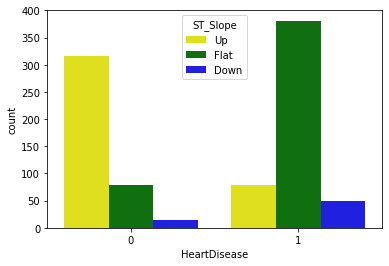

In [51]:
sns.countplot(x="HeartDisease", hue='ST_Slope', data=heart, palette=['yellow', 'green', 'blue'])

Similarly, we can generate bar plots split by `HeartDisease` and `Sex` on all of our numerical columns to determine how scores differ across gender and heart disease. 

<AxesSubplot:xlabel='HeartDisease', ylabel='RestingBP'>

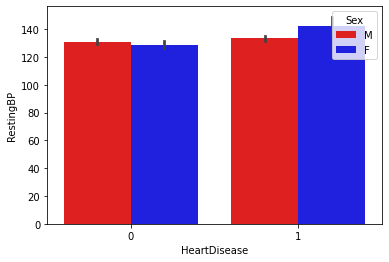

In [52]:
clrs=['red', 'blue']
sns.barplot(x='HeartDisease', y='RestingBP', hue='Sex', data=heart, palette=clrs)

<AxesSubplot:xlabel='HeartDisease', ylabel='Cholesterol'>

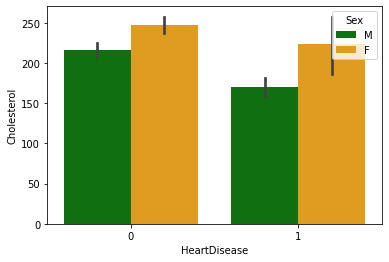

In [53]:
clrs=['green', 'orange']
sns.barplot(x='HeartDisease', y='Cholesterol', hue='Sex', data=heart, palette=clrs)

<AxesSubplot:xlabel='HeartDisease', ylabel='FastingBS'>

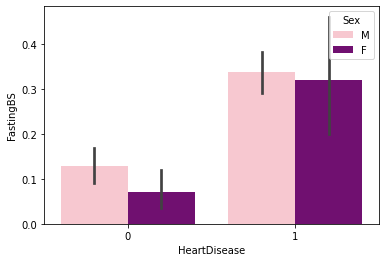

In [54]:
clrs=['pink', 'purple']
sns.barplot(x='HeartDisease', y='FastingBS', hue='Sex', data=heart, palette=clrs)

<AxesSubplot:xlabel='HeartDisease', ylabel='MaxHR'>

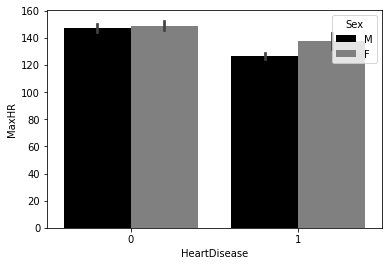

In [55]:
sns.barplot(x='HeartDisease', y='MaxHR', hue='Sex', data=heart, palette=['black', 'grey'])

<AxesSubplot:xlabel='HeartDisease', ylabel='Oldpeak'>

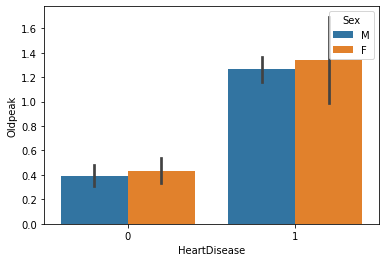

In [56]:
sns.barplot(x='HeartDisease', y='Oldpeak', hue='Sex', data=heart)

### Data Analysis

After exploring the data and extracting some basic information, we can begin to prepare our data for our model. Firstly, before we begin, let's split our data into training and testing set. Remember that the purpose of this analysis is to classify patients with and without heart disease using the features, `X`, so that is our target `y`. 

We can do this using the `train_test_split` method in the `sklearn` package. We selected 25% of our data to be used for training and 75% to be used for testing. 

In [57]:
!pip install -U scikit-learn

from sklearn.preprocessing import StandardScaler

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [58]:
from sklearn.model_selection import train_test_split

features = ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']
X = heart.loc[:, features]
y = heart.loc[:, ['HeartDisease']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size = .75)

Now, we can begin to transform the data. Since this is a classification problem, we should begin with the LogisticRegression model, whose implementation in the `sklearn` package requires all data to be numerical. 

For our categorical columns, we can use encoding to convert the data to numerical. In this specific case, all of our columns do not have values that are ordinally labeled or that can be split into levels of increasing or decreasing value. Therefore, we can use one-hot encoding for each categorical column. 

For our numerical columns, we can apply scaling because their corresponding distributions have some skews, as identified during the data exploration phase. Here, we used standard scaling, we subtract the mean of the distribution and scale by unit variance. This results in values that are all around the same range.

Below, we have created two transformers; one that uses `OneHotEncoder` on the categorical columns and one that uses `StandardScaler` on the remaining numerical columns.

We then apply the transformers separately on the training data and print some information about the transformed training data set. 

In [59]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

transformer1 = ColumnTransformer([
    ('ohe', OneHotEncoder(), ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'])], 
    remainder='passthrough')

transformer2 = ColumnTransformer([
    ('ss', StandardScaler(), ['remainder__Age', 'remainder__RestingBP', 'remainder__Cholesterol', 'remainder__FastingBS', 'remainder__MaxHR', 'remainder__Oldpeak'])],
    remainder='passthrough')


transformed1 = transformer1.fit_transform(X_train)
X_train_transformed = pd.DataFrame(transformed1, columns=transformer1.get_feature_names_out())

transformed2 = transformer2.fit_transform(X_train_transformed)
X_train_transformed2 = pd.DataFrame(transformed2, columns=transformer2.get_feature_names_out())

X_train_transformed2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688 entries, 0 to 687
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ss__remainder__Age                 688 non-null    float64
 1   ss__remainder__RestingBP           688 non-null    float64
 2   ss__remainder__Cholesterol         688 non-null    float64
 3   ss__remainder__FastingBS           688 non-null    float64
 4   ss__remainder__MaxHR               688 non-null    float64
 5   ss__remainder__Oldpeak             688 non-null    float64
 6   remainder__ohe__Sex_F              688 non-null    float64
 7   remainder__ohe__Sex_M              688 non-null    float64
 8   remainder__ohe__ChestPainType_ASY  688 non-null    float64
 9   remainder__ohe__ChestPainType_ATA  688 non-null    float64
 10  remainder__ohe__ChestPainType_NAP  688 non-null    float64
 11  remainder__ohe__ChestPainType_TA   688 non-null    float64

Now, we can apply the same transformations to the testing data set.

In [60]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression

transformed1t = transformer1.fit_transform(X_test)
X_test_transformed = pd.DataFrame(transformed1t, columns=transformer1.get_feature_names_out())

transformed2t = transformer2.fit_transform(X_test_transformed)
X_test_transformed2 = pd.DataFrame(transformed2t, columns=transformer2.get_feature_names_out())

Finally, with our two datasets, we can first fit the regressor, `LogisticRegression`, to our transformed training data. Likewise, we can predict our y variable using testing data and and calculate our regressor score, which is an r^2 value. Our accuracy is around 86%, which is fair performance for our model.

In [61]:
regressor = LogisticRegression()


regressor.fit(X_train_transformed2, y_train)
y_pred = regressor.predict(X_test_transformed2)
regressor.score(X_test_transformed2, y_test)


/Users/sakeena/Library/Python/3.8/lib/python/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8695652173913043

We can take a deeper dive into our model by printing a confusion matrix. Our model correctly predicted 87 patients who have heart disease and 113 patients who do not have heart disease. In other words, our model had 87 true positives and 113 true negatives. It appears that our model incorrectly predicted 11 people to have heart disease and 19 people not to have heart disease. There are slightly more patients with heart disease in the dataset, so perhaps it might improve the accuracy of our model if more patients without heart disease are added.

In [62]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)
        

array([[ 87,  11],
       [ 19, 113]])

Rather than using our `train_test_split` method, we can perform cross validation to make us more confident that our model is correctly being trained on the training data. It guarantees that our model performance in this case, 86%, is not dependent on how we split our data into train and test sets. First, we concatenate our train and test set after they atr transformed.

In [63]:
X_merged = pd.concat([X_train_transformed2,X_test_transformed2], ignore_index=True)
y_merged = pd.concat([y_train, y_test], ignore_index=True)

Here, we are using k-fold cross validation with 10 folds. This means our data set is split into 10 subsets, 9 of which composes our training set and the remaining one is used as our test set. This process is run 10 times so that each subset has an opportunity to be a test set. Then, the accuracy scores of each run are averaged, which results in a k-fold cross validation score.

Our performance metric here is 0.862, or 86.2% accuracy, which is similar to our initial metric.

In [64]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

cv = KFold(n_splits=10, random_state=1, shuffle=True)
# create model
model = LogisticRegression()
# evaluate model
scores = cross_val_score(model, X_merged, y_merged, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.862 (0.026)
